In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_mnist_test_files function

from generate_input_files.generate_mnist_test_files import generate_mnist_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [3]:
# Define paths and configurations
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "increasing_epochs_test_storage")
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "storage", "increasing_epochs_test_storage")

# Step 1: Generate MNIST test files
print("Generating MNIST test files...")
generated_files = generate_mnist_test_files(tmp_folder)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_filename = generated_files["model"]

Generating MNIST test files...
MNIST images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test_storage\mnist_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test_storage\mnist_definition.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test_storage\mnist_dataset.zip
Model saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test_storage\mnist_model.keras
File generation completed.


In [4]:
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the epoch counts to test
epoch_counts = [1, 2, 5, 10, 50]
epoch_mapping = {}  # Dictionary to map epochs to unique_dir and job_id

# Step 2: Submit jobs with increasing epochs
for epochs in epoch_counts:
    print(f"\nSubmitting job with {epochs} epochs...")

    # Prepare the files and data for the request
    files = {
        "model": open(model_filename, "rb"),
        "dataset": open(dataset_filename, "rb"),
        "dataset_definition": open(yaml_filename, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"storage_analysis_model_{epochs}_epochs",
        "epochs": epochs,
    }

    # Submit the job
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted: {response.status_code} {response.text}")

    # Extract the unique_dir and job_id from the API response
    response_data = response.json()
    unique_dir = response_data.get("unique_dir")
    job_id = response_data.get("job_id")  # Assuming the API returns a job_id
    if not unique_dir:
        raise ValueError("Error: 'unique_dir' not found in the API response.")

    # Store the mapping
    epoch_mapping[epochs] = {"unique_dir": unique_dir, "job_id": job_id}

    # Wait for the job to finish and download the results
    print(f"Waiting for job with {epochs} epochs to complete...")
    wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
    print(f"Artifacts for {epochs} epochs downloaded to: {DOWNLOAD_DIR}")


Submitting job with 1 epochs...
Submitted: 200 {"job_id":"00492c88-4ef8-4de0-a258-f235733dc0e5","status":"Training started","unique_dir":"e46ae79c-812c-49fc-977c-39c4d261a5b7"}
Waiting for job with 1 epochs to complete...
Checking if job is finished by looking for 'output' folder in 'e46ae79c-812c-49fc-977c-39c4d261a5b7'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'e46ae79c-812c-49fc-977c-39c4d261a5b7'...
Downloaded: e46ae79c-812c-49fc-977c-39c4d261a5b7/dataset/mnist_dataset.zip -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\storage\increasing_epochs_test_storage\e46ae79c-812c-49fc-977c-39c4d261a5b7/dataset/mnist_dataset.zip
Downloaded: e46ae79c-812c-49fc-977c-39c4d261a5b7/definition/mnist_definition.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\storage\increasing_epochs_test_storage\e46ae79c-812c-49fc-977c-39c4d261a5b7/definit

   Epochs  Dataset Size (KB)  Definition Size (KB)  Input Model Size (KB)  \
0       1        1923.439453               0.12207             2738.69043   
1       2        1923.439453               0.12207             2738.69043   
2       5        1923.439453               0.12207             2738.69043   
3      10        1923.439453               0.12207             2738.69043   
4      50        1923.439453               0.12207             2738.69043   

   Trained Model Size (KB)  AIBOM Size (KB)  Logs Size (KB)  \
0              8163.098633        13.466797        4.251953   
1              8163.098633        13.537109        4.251953   
2              8163.098633        13.779297        4.251953   
3              8163.098633        14.173828        4.251953   
4              8163.098633        17.331055        4.251953   

   Metrics Size (KB)  RunLink Size (KB)  Total Job Folder Size (KB)  \
0           0.132812           1.267578                12844.469727   
1           0.20

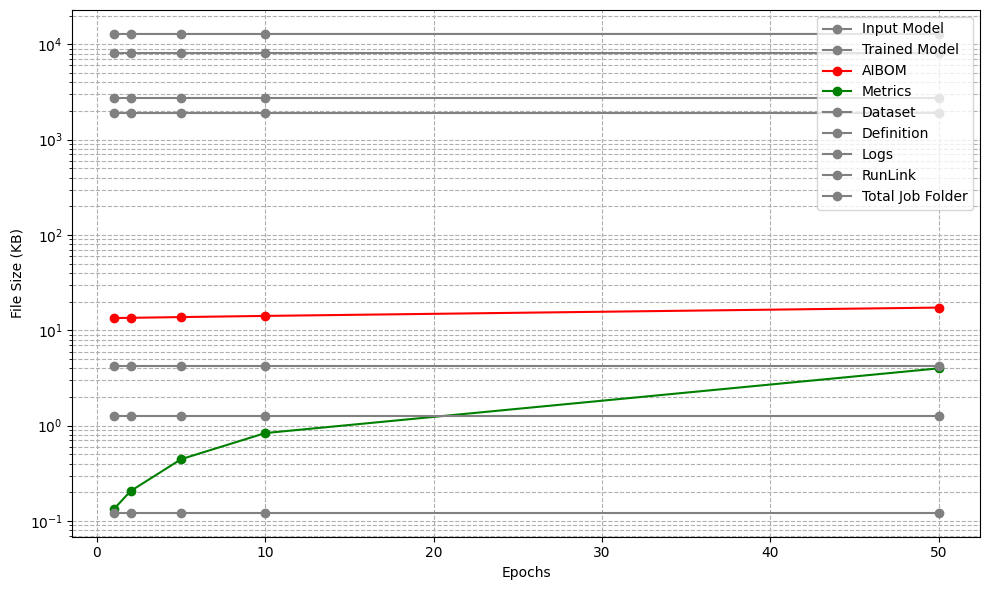

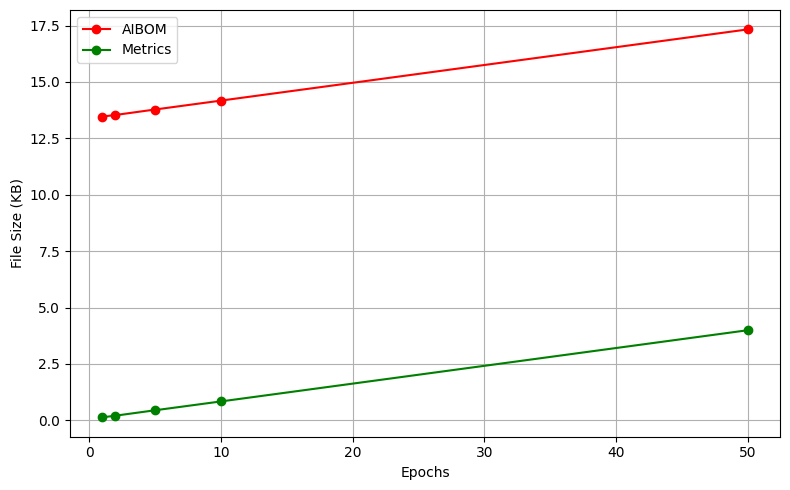

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Define the path to the job result folders
results_dir = Path(DOWNLOAD_DIR)  # Use the DOWNLOAD_DIR defined earlier

# Extract data for analysis
epochs_list = list(epoch_mapping.keys())  # Extract epochs from the mapping
dataset_sizes = []
definition_sizes = []
model_sizes = []
trained_model_sizes = []
aibom_sizes = []
logs_sizes = []
metrics_sizes = []
runlink_sizes = []
total_folder_sizes = []

# Process each job folder
for epochs, info in epoch_mapping.items():
    unique_dir = info["unique_dir"]
    folder_path = results_dir / unique_dir

    # Top-level files
    dataset_file = folder_path / "dataset" / "mnist_dataset.zip"
    definition_file = folder_path / "definition" / "mnist_definition.yaml"
    model_file = folder_path / "model" / "mnist_model.keras"
    # Output files
    output_path = folder_path / "output"
    trained_model_file = output_path / "trained_model.keras"
    aibom_file = output_path / "cyclonedx_bom.json"
    logs_file = output_path / "logs.log"
    metrics_file = output_path / "metrics.json"
    runlink_file = next(output_path.glob("run_training.*.link"), None)

    # Get sizes in KB (handle missing files gracefully)
    dataset_sizes.append(dataset_file.stat().st_size / 1024 if dataset_file.exists() else None)
    definition_sizes.append(definition_file.stat().st_size / 1024 if definition_file.exists() else None)
    model_sizes.append(model_file.stat().st_size / 1024 if model_file.exists() else None)
    trained_model_sizes.append(trained_model_file.stat().st_size / 1024 if trained_model_file.exists() else None)
    aibom_sizes.append(aibom_file.stat().st_size / 1024 if aibom_file.exists() else None)
    logs_sizes.append(logs_file.stat().st_size / 1024 if logs_file.exists() else None)
    metrics_sizes.append(metrics_file.stat().st_size / 1024 if metrics_file.exists() else None)
    runlink_sizes.append(runlink_file.stat().st_size / 1024 if runlink_file and runlink_file.exists() else None)

    # Calculate total folder size in KB
    total_size = sum(f.stat().st_size for f in folder_path.rglob('*') if f.is_file()) / 1024
    total_folder_sizes.append(total_size)

# Create a DataFrame for analysis
df = pd.DataFrame({
    "Epochs": epochs_list,
    "Dataset Size (KB)": dataset_sizes,
    "Definition Size (KB)": definition_sizes,
    "Input Model Size (KB)": model_sizes,
    "Trained Model Size (KB)": trained_model_sizes,
    "AIBOM Size (KB)": aibom_sizes,
    "Logs Size (KB)": logs_sizes,
    "Metrics Size (KB)": metrics_sizes,
    "RunLink Size (KB)": runlink_sizes,
    "Total Job Folder Size (KB)": total_folder_sizes,
    "AIBOM % of Trained Model": [100 * a / m if m else None for a, m in zip(aibom_sizes, trained_model_sizes)]
})
print(df)

df.to_csv(os.path.join(DOWNLOAD_DIR, "storage_analysis_epoch_results.csv"), index=False)

# Plot 1: File Sizes vs Epochs (Log Scale)
plt.figure(figsize=(10, 6))
plt.plot(df["Epochs"], df["Input Model Size (KB)"], marker='o', label="Input Model", color="gray")
plt.plot(df["Epochs"], df["Trained Model Size (KB)"], marker='o', label="Trained Model", color="gray")
plt.plot(df["Epochs"], df["AIBOM Size (KB)"], marker='o', label="AIBOM", color="red")
plt.plot(df["Epochs"], df["Metrics Size (KB)"], marker='o', label="Metrics", color="green")
plt.plot(df["Epochs"], df["Dataset Size (KB)"], marker='o', label="Dataset", color="gray")
plt.plot(df["Epochs"], df["Definition Size (KB)"], marker='o', label="Definition", color="gray")
plt.plot(df["Epochs"], df["Logs Size (KB)"], marker='o', label="Logs", color="gray")
plt.plot(df["Epochs"], df["RunLink Size (KB)"], marker='o', label="RunLink", color="gray")
plt.plot(df["Epochs"], df["Total Job Folder Size (KB)"], marker='o', label="Total Job Folder", color="gray")

plt.xlabel("Epochs")
plt.ylabel("File Size (KB)")
plt.yscale("log")
plt.legend(loc="upper right")  # Move legend to the upper-right corner
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Plot 2: AIBOM and Metrics File Sizes vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(df["Epochs"], df["AIBOM Size (KB)"], marker='o', label="AIBOM", color="red")
plt.plot(df["Epochs"], df["Metrics Size (KB)"], marker='o', label="Metrics", color="green")
plt.xlabel("Epochs")
plt.ylabel("File Size (KB)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()